## Credit Risk Classification

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## EDA

In [2]:
#read/open the dataset
path = r'\data'


#the first column is the index
df = pd.read_csv(path + '\german_credit_data.csv', index_col='Unnamed: 0')

In [3]:
#overview of the dataset
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


The target variable is 'Risk', which is what we want to predict.

In [4]:
#There are 1000 rows and 10 features in the dataset
df.shape

(1000, 10)

There is an interesting observation we can make by looking at the below information. There are
twice as many men than women who have applied and received credit. Moreover men tend to apply and receive credit a later stage of their lives.

In [5]:
#distribution between men and women
print('Distibution based on gender:\n' + str(df['Sex'].value_counts()), '\n')
print(df.groupby('Sex')['Age'].mean())

Distibution based on gender:
male      690
female    310
Name: Sex, dtype: int64 

Sex
female    32.803226
male      36.778261
Name: Age, dtype: float64


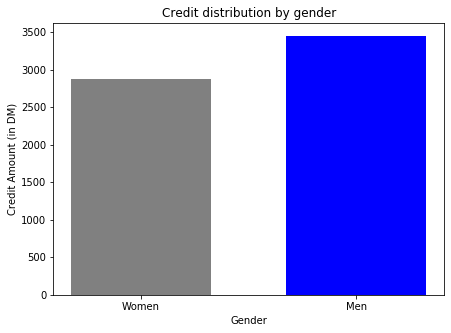

In [6]:
#preparing the data for the barplot
list1 = [i for i in df.groupby('Sex')['Credit amount'].mean()]
labels = ['Women', 'Men']
colors = ['gray', 'b']

#barplot showing the average credit amount that each gender receives
fig = plt.figure(figsize=(7,5))
plt.bar(labels, list1, color=colors, width=0.65)
plt.ylabel('Credit Amount (in DM)')
plt.xlabel('Gender')
plt.title('Credit distribution by gender')
plt.show()

It is evident from the above barplot that men get an approximately **19%** higher credit amount than women.

We now want to see the purpose that each customer applies and  receives credit for.

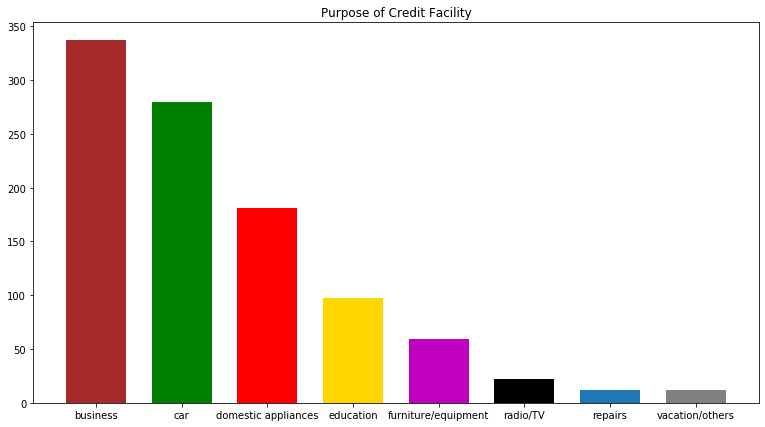

In [7]:
#preparing the data for the barplot
purpose = np.unique(df['Purpose'])
no_purpose = df['Purpose'].value_counts()
colors_1 = ['brown','g','r', 'gold', 'm', 'k', 'tab:blue', 'gray']

#Plot showing the reason for credit
plt.figure(figsize=(13,7))
plt.bar(purpose, no_purpose, color=colors_1, width=0.7)
plt.title('Purpose of Credit Facility')
plt.show()

Most customers, around 34%, receive credit for business purposes. Car loans are quite popular, as well as credit for house appliances. On the other hand, credit for holidays and repairs are rarely been given.


Let's have a look at the distribution of ages in the dataset. We are going to use a boxplot for this.

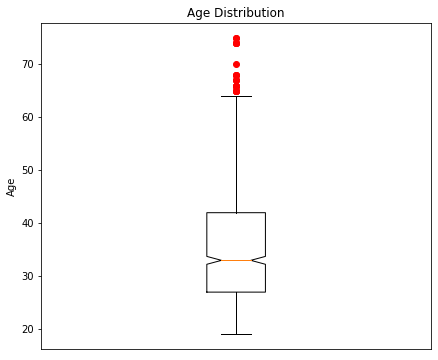

In [8]:
#boxplot
fig, ax1 = plt.subplots(figsize=(7,6))
ax1.boxplot(df['Age'], notch=True, sym='r')
ax1.set_title('Age Distribution')
ax1.set_xticks([])
ax1.set_ylabel('Age')
plt.show()

The median age is around the age of 33 and most customers who received credit are between ages 27 - 41. It is also evident that there are some outliers, specifically Ages above 63. <br>
We also want to check whether our dataset is *balanced* or not. 

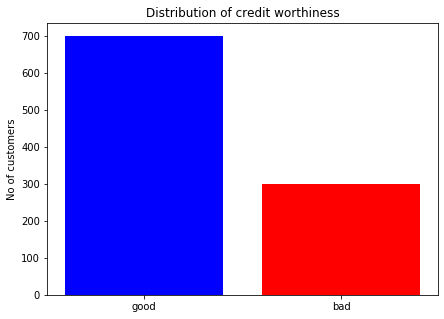

In [9]:
#setting variables for the barplot
good_risk = df['Risk'].value_counts()[0]
bad_risk = df['Risk'].value_counts()[1]
no_risk = [good_risk, bad_risk]

#barplot of distribution of credit worthiness
plt.figure(figsize=(7,5))
plt.bar(['good','bad'], no_risk, color=['b','r'])
plt.title('Distribution of credit worthiness')
plt.ylabel('No of customers')
plt.show()

It turns out that in this case we are dealing with an imbalanced dataset. There are 700 customers with a good credit rating, whereas the remaining 300 have a bad one. We need to consider if we need to deploy an under/oversampling technique.

We also want to visualize the probability distribution of the credit amount and duration period (in months) of each credit facility. This can be achieved by using **violin plots**.

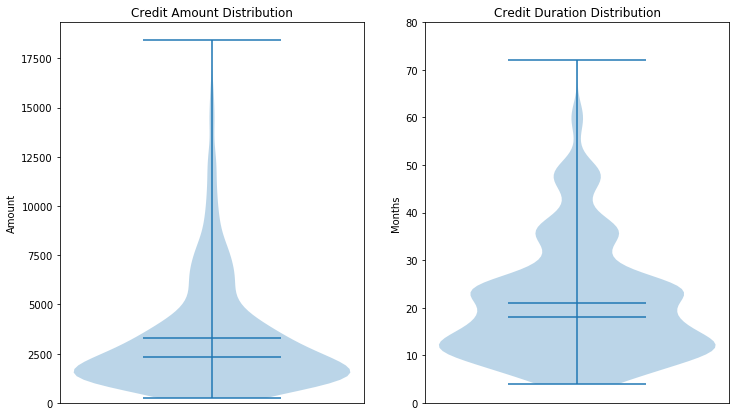

In [10]:
#setting max values
max_duration = np.max(df['Duration']) + 10
max_amount = np.max(df['Credit amount']) + 1000

#violin plots on credit amount and duration period of credit facility
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axs[0].violinplot(df['Credit amount'], showmeans=True, showextrema=True, showmedians=True)
axs[0].set_ylim(ymin=0)
axs[0].set_yticks(np.arange(0, max_amount, step=2500))
axs[0].set_ylabel('Amount')
axs[0].set_xticks([])
axs[0].set_title('Credit Amount Distribution')
#secondplot
axs[1].violinplot(df['Duration'], showmeans=True, showextrema=True, showmedians=True)
axs[1].set_title('Credit Duration Distribution')
axs[1].set_yticks(np.arange(0, max_duration, step=10))
axs[1].set_xticks([])
axs[1].set_ylabel('Months')
plt.show()

Let's have a look at the relationship between risk and job. Firstly, the labels and the category they correspond to can be found below:

- 0 - unskilled and non-resident 
- 1 - unskilled and resident 
- 2 - skilled
- 3 - highly skilled

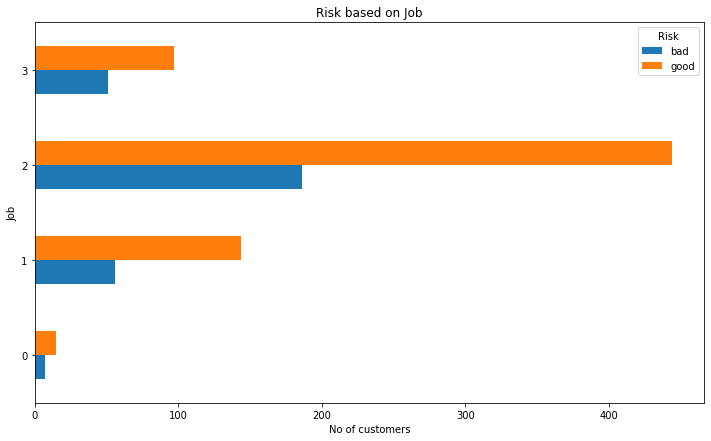

In [11]:
#preparing the data
job_risk = pd.crosstab(df['Job'],df['Risk'])
#horizontal barplot
job_risk.plot.barh(figsize=(12,7))
plt.title('Risk based on Job')
plt.xlabel('No of customers')
plt.show()

We can now look into the relationship between Housing and Risk. We want to identify what is the risk rating of customers based on their housing situation.

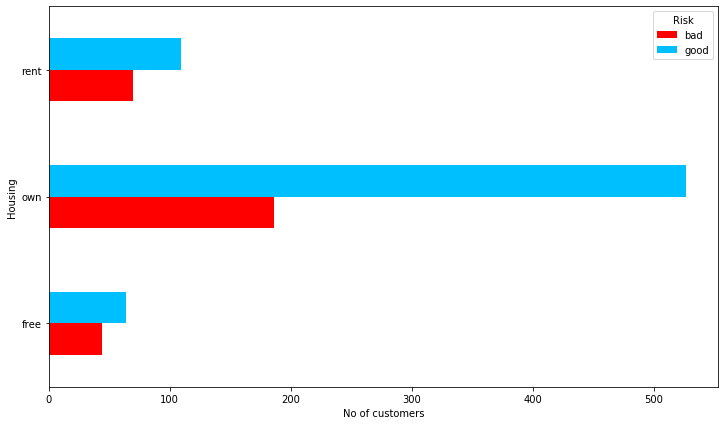

In [12]:
#preparing the data
house_risk = pd.crosstab(df['Housing'], df['Risk'])
#visualizing the data using a horizontal barplot
house_risk.plot.barh(figsize=(12,7), color=['r','deepskyblue'])
plt.xlabel('No of customers')
plt.show()

## Preprocessing